In [1]:
#load dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load in the collected data
df = pd.read_json('dataframes/reddit_data.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14770 entries, c1e4o to c0i10ti
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   score             14770 non-null  int64 
 1   controversiality  14770 non-null  int64 
 2   subreddit         14770 non-null  object
 3   body              14770 non-null  object
 4   month             14770 non-null  int64 
 5   year              14770 non-null  int64 
 6   original_size     14770 non-null  int64 
 7   PS                14770 non-null  int64 
 8   XBOX              14770 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.1+ MB


First let's take a look at the correlation of numeric, boolean, and categorical data.
The body column is the unique message of each post, and will be explored at a later point.
In addition, original_size is just the number of posts in that year/month combination and
will not be useful in looking at correlations.

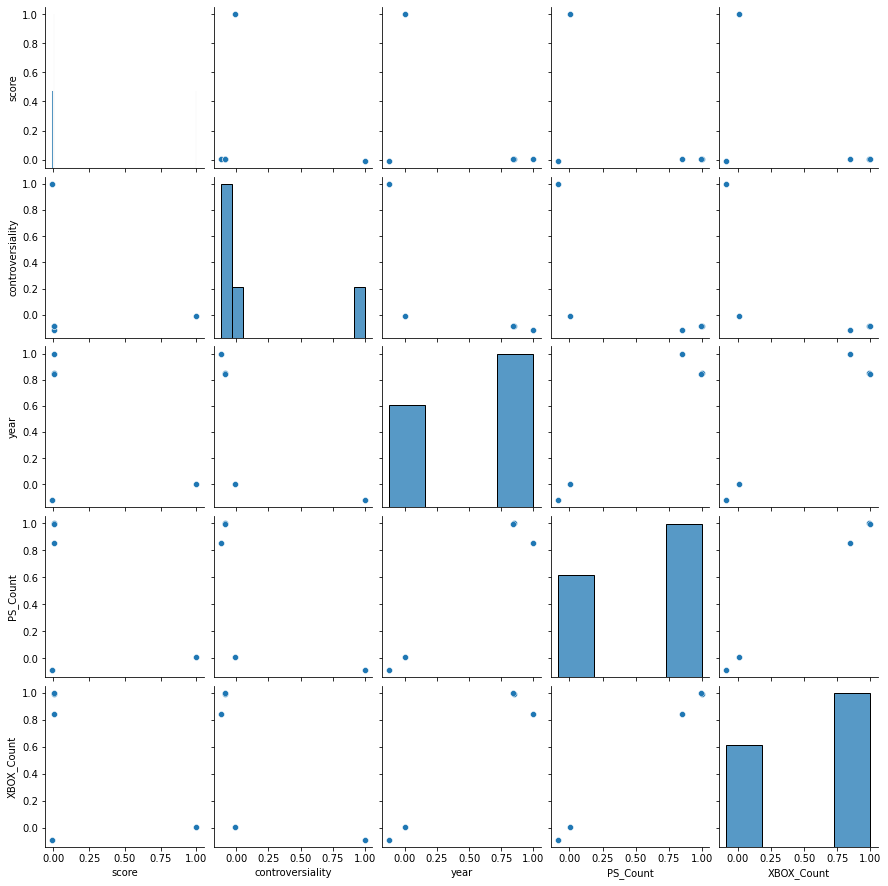

In [3]:
df['PS_Count'] = df['PS'].cumsum() * 100 / df['original_size']
df['XBOX_Count'] = df['XBOX'].cumsum() * 100 / df['original_size']

corr_df = df[['score', 'controversiality', 'subreddit', 'year', 'PS_Count', 'XBOX_Count']]
sns.pairplot(corr_df.corr())
plt.show()

Not a ton of useful information here.  PS_Count and XBOX_Count are both positively correlated
with year and each other, as both useage of Reddit since its inception in 2005 and talk of the 
consoles have increased over the years.  
What is interesting about that though is that the two count columns are percents of 
overall Reddit comments, meaning PS and XBOX have become increasing popular topics of conversation.

As one might expect, controversiality and score are negatively correlated.
Looking at the heatmap below, they're negatively correlated with everything else as well.
This is because controversiality only has two values: 0 and 1, the latter only shows up 15 times, 
all of which were in 2006 and 2007.
Score, meanwhile has a wide variance, with about 11k/14.5k entries being between 0 and 4 but overall
ranging from -45 to 398.

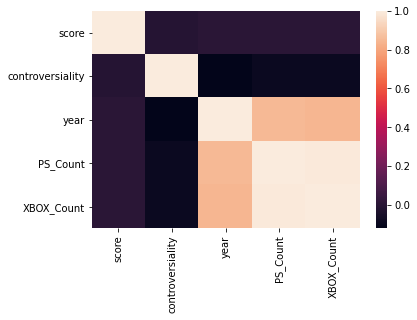

In [4]:
sns.heatmap(corr_df.corr())
plt.show()

To visualize Score's data with and without outliers, I made the histograms below.

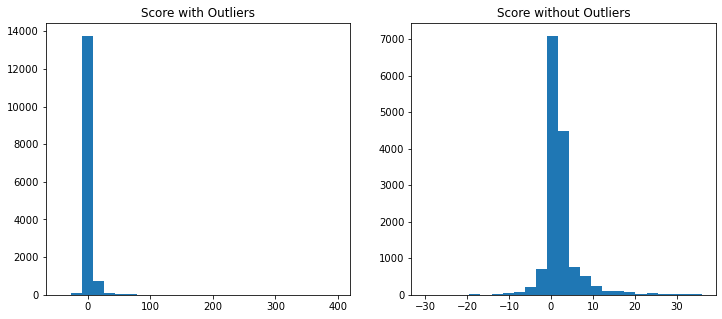

In [5]:
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
bins = 25
axs[0].hist(df['score'], bins=bins)

m = df['score'].mean()
std = 3 * df['score'].std()
axs[1].hist(df['score'][(df['score'] >= (m-std)) & (df['score'] <= (m+std))], bins=bins)

axs[0].set_title('Score with Outliers')
axs[1].set_title('Score without Outliers')
plt.show()

Below I am plotting the number of instances of PS and XBOX comments over time.

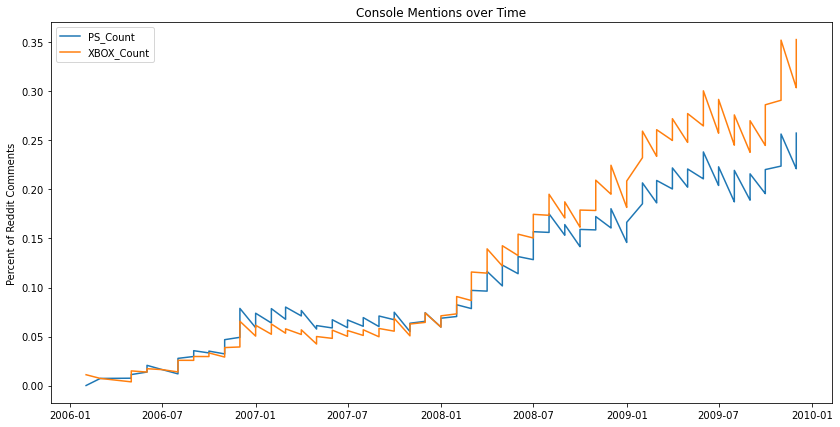

In [64]:
df['date'] = df['month'].astype(str) + '/' + df['year'].astype(str)
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(14,7))
plt.plot('date', 'PS_Count', data=df)
plt.plot('date', 'XBOX_Count', data=df)

plt.legend()
plt.title('Console Mentions over Time')
plt.ylabel('Percent of Reddit Comments')
plt.show()

Since there wasn't a day of the month included in the data, the graph above has a step function appearance.
Both sets scale exponentially due to more frequent use of Reddit as time goes on, 
hence the percentage of mentions rather than count.
It looks like PS has a slight lead in mentions initially, but XBOX eventually took over in early 2008.
Percent of Reddit Comments are all less than 1% for clarification.

In [65]:
#plotting Counts by Subreddit

#create a filtering mask to only show subreddits that have more than 10 mentions apiece to avoid an oversized graph
subreddit_mask = df['subreddit'].value_counts() > 10
subreddit_mask.replace(False, np.nan, inplace=True)
subreddit_mask.dropna(inplace=True)
subreddit_df = df[df['subreddit'].isin(subreddit_mask.index)]

subreddit_df['PS_Subreddit_Count'] = subreddit_df['subreddit']
subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['subreddit']
for subreddit in subreddit_mask.index:
    base_df = subreddit_df[subreddit_df['subreddit']==subreddit]
    ps_sub = base_df[base_df['PS']==True]
    xbox_sub = base_df[base_df['XBOX']==True]
    ps_count = ps_sub['PS'].count()
    xbox_count = xbox_sub['XBOX'].count()

    subreddit_df['PS_Subreddit_Count'].replace(subreddit, str(ps_count), inplace=True)
    subreddit_df['XBOX_Subreddit_Count'].replace(subreddit, str(xbox_count), inplace=True)
    
subreddit_df['PS_Subreddit_Count'] = subreddit_df['PS_Subreddit_Count'].astype(int)
subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['XBOX_Subreddit_Count'].astype(int)

<ipython-input-65-6190ae284e5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df['PS_Subreddit_Count'] = subreddit_df['subreddit']
<ipython-input-65-6190ae284e5f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['subreddit']
C:\Users\rlybb\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

<ipython-input-66-281cf78354da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df.sort_values(by='XBOX_Subreddit_Count', inplace=True, ascending=False)


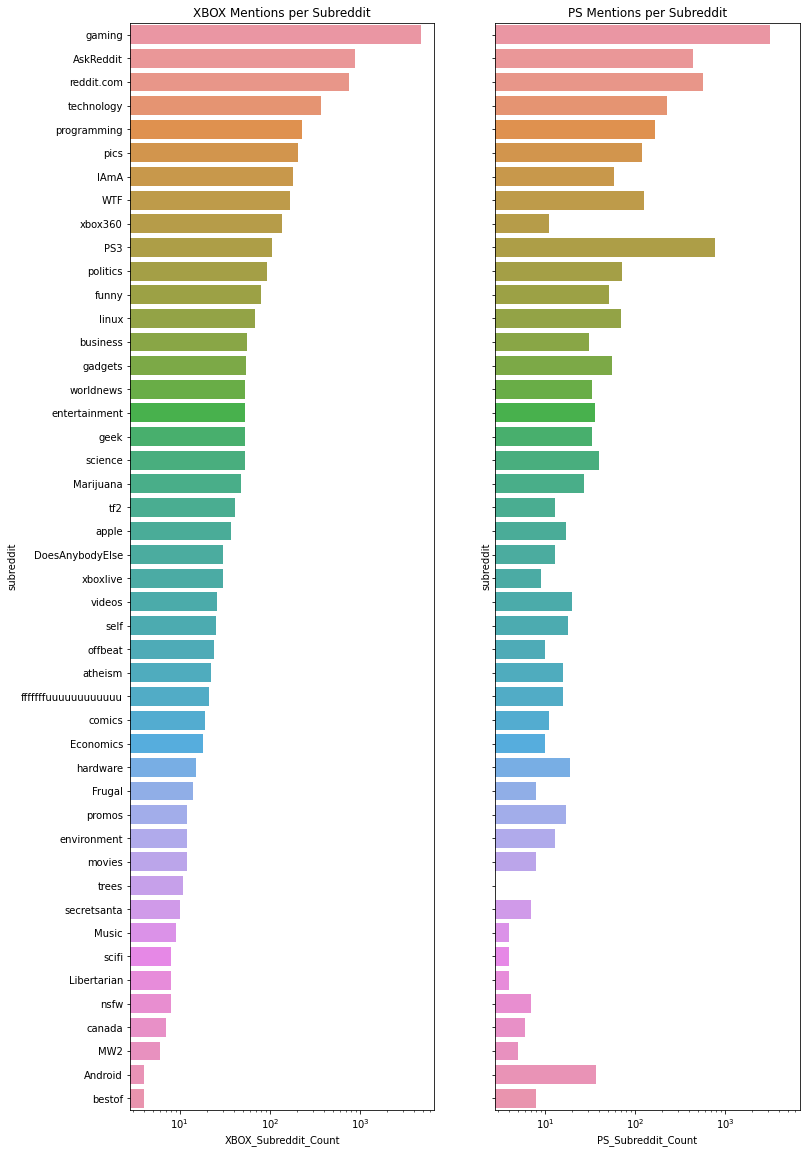

In [66]:
subreddit_df.sort_values(by='XBOX_Subreddit_Count', inplace=True, ascending=False)

figs, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 20))
sns.barplot(x='XBOX_Subreddit_Count', y='subreddit', data=subreddit_df, ax=axs[0])
axs[0].set_title('XBOX Mentions per Subreddit')
axs[0].set_xscale('log')

sns.barplot(x='PS_Subreddit_Count', y='subreddit', data=subreddit_df, ax=axs[1])
axs[1].set_title('PS Mentions per Subreddit')
plt.show()

The above barplots separate number of mentions by subreddit.  
Unsurprisingly, Gaming is the most popular subreddit for both XBOX and PS, 
followed by PS3 for PS, askreddit and reddit.com, technology, and programming.
Note that reddit.com is a placeholder for posts before subreddits were created in 2008.
Once again, the data is shown on a logarithmic scale due to the exponential behavior of posts on Reddit.

Onto displaying the body column.  As this represents the actual Reddit comments, EDA is a bit tricky.
In this case, I'll be running TextBlob's sentiment function to get a feel for the average mood of different
posts, and creating a word cloud to show the most frequent words used.

In [67]:
from textblob import TextBlob

def sentiment_analysis(paragraph):
    body_text = TextBlob(paragraph)
    return(body_text.sentiment[0])

def paragraph_cleanse(paragraph):
    #modify contractions
    paragraph = paragraph.replace("'", "")
    
    #lowercase everything
    paragraph = paragraph.lower()
    
    #remove punctuation and excess spacing
    for char in ['`', '~', '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '=', '+', '[', '{', ']', '}', '|',
                 '\\', ':', ';', '"', ',', '<', '.', '>', '/', '?']:
        paragraph = paragraph.replace(char, ' ')
        paragraph = paragraph.replace('  ', ' ')
    
    return(paragraph)
        
df['naive_sentiment'] = df['body'].apply(sentiment_analysis)
df['body'] = df['body'].apply(paragraph_cleanse)

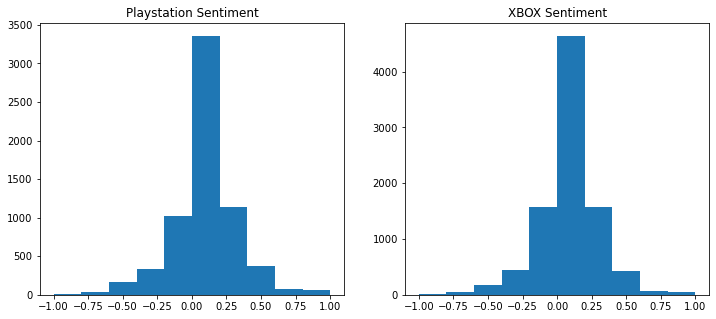

In [68]:
figs, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(12, 5))
axs[0].hist(df['naive_sentiment'][df['PS']==True])
axs[1].hist(df['naive_sentiment'][df['XBOX']==True])

axs[0].set_title('Playstation Sentiment')
axs[1].set_title('XBOX Sentiment')
plt.show()

It looks like the ratio of each console's sentiment is roughly the same,
with PS having slightly more values above 0.5
(XBOX has more overall mentions, hence why I didn't set the y-axis to match).
Sentiment is measured on a scale of -1 to 1.

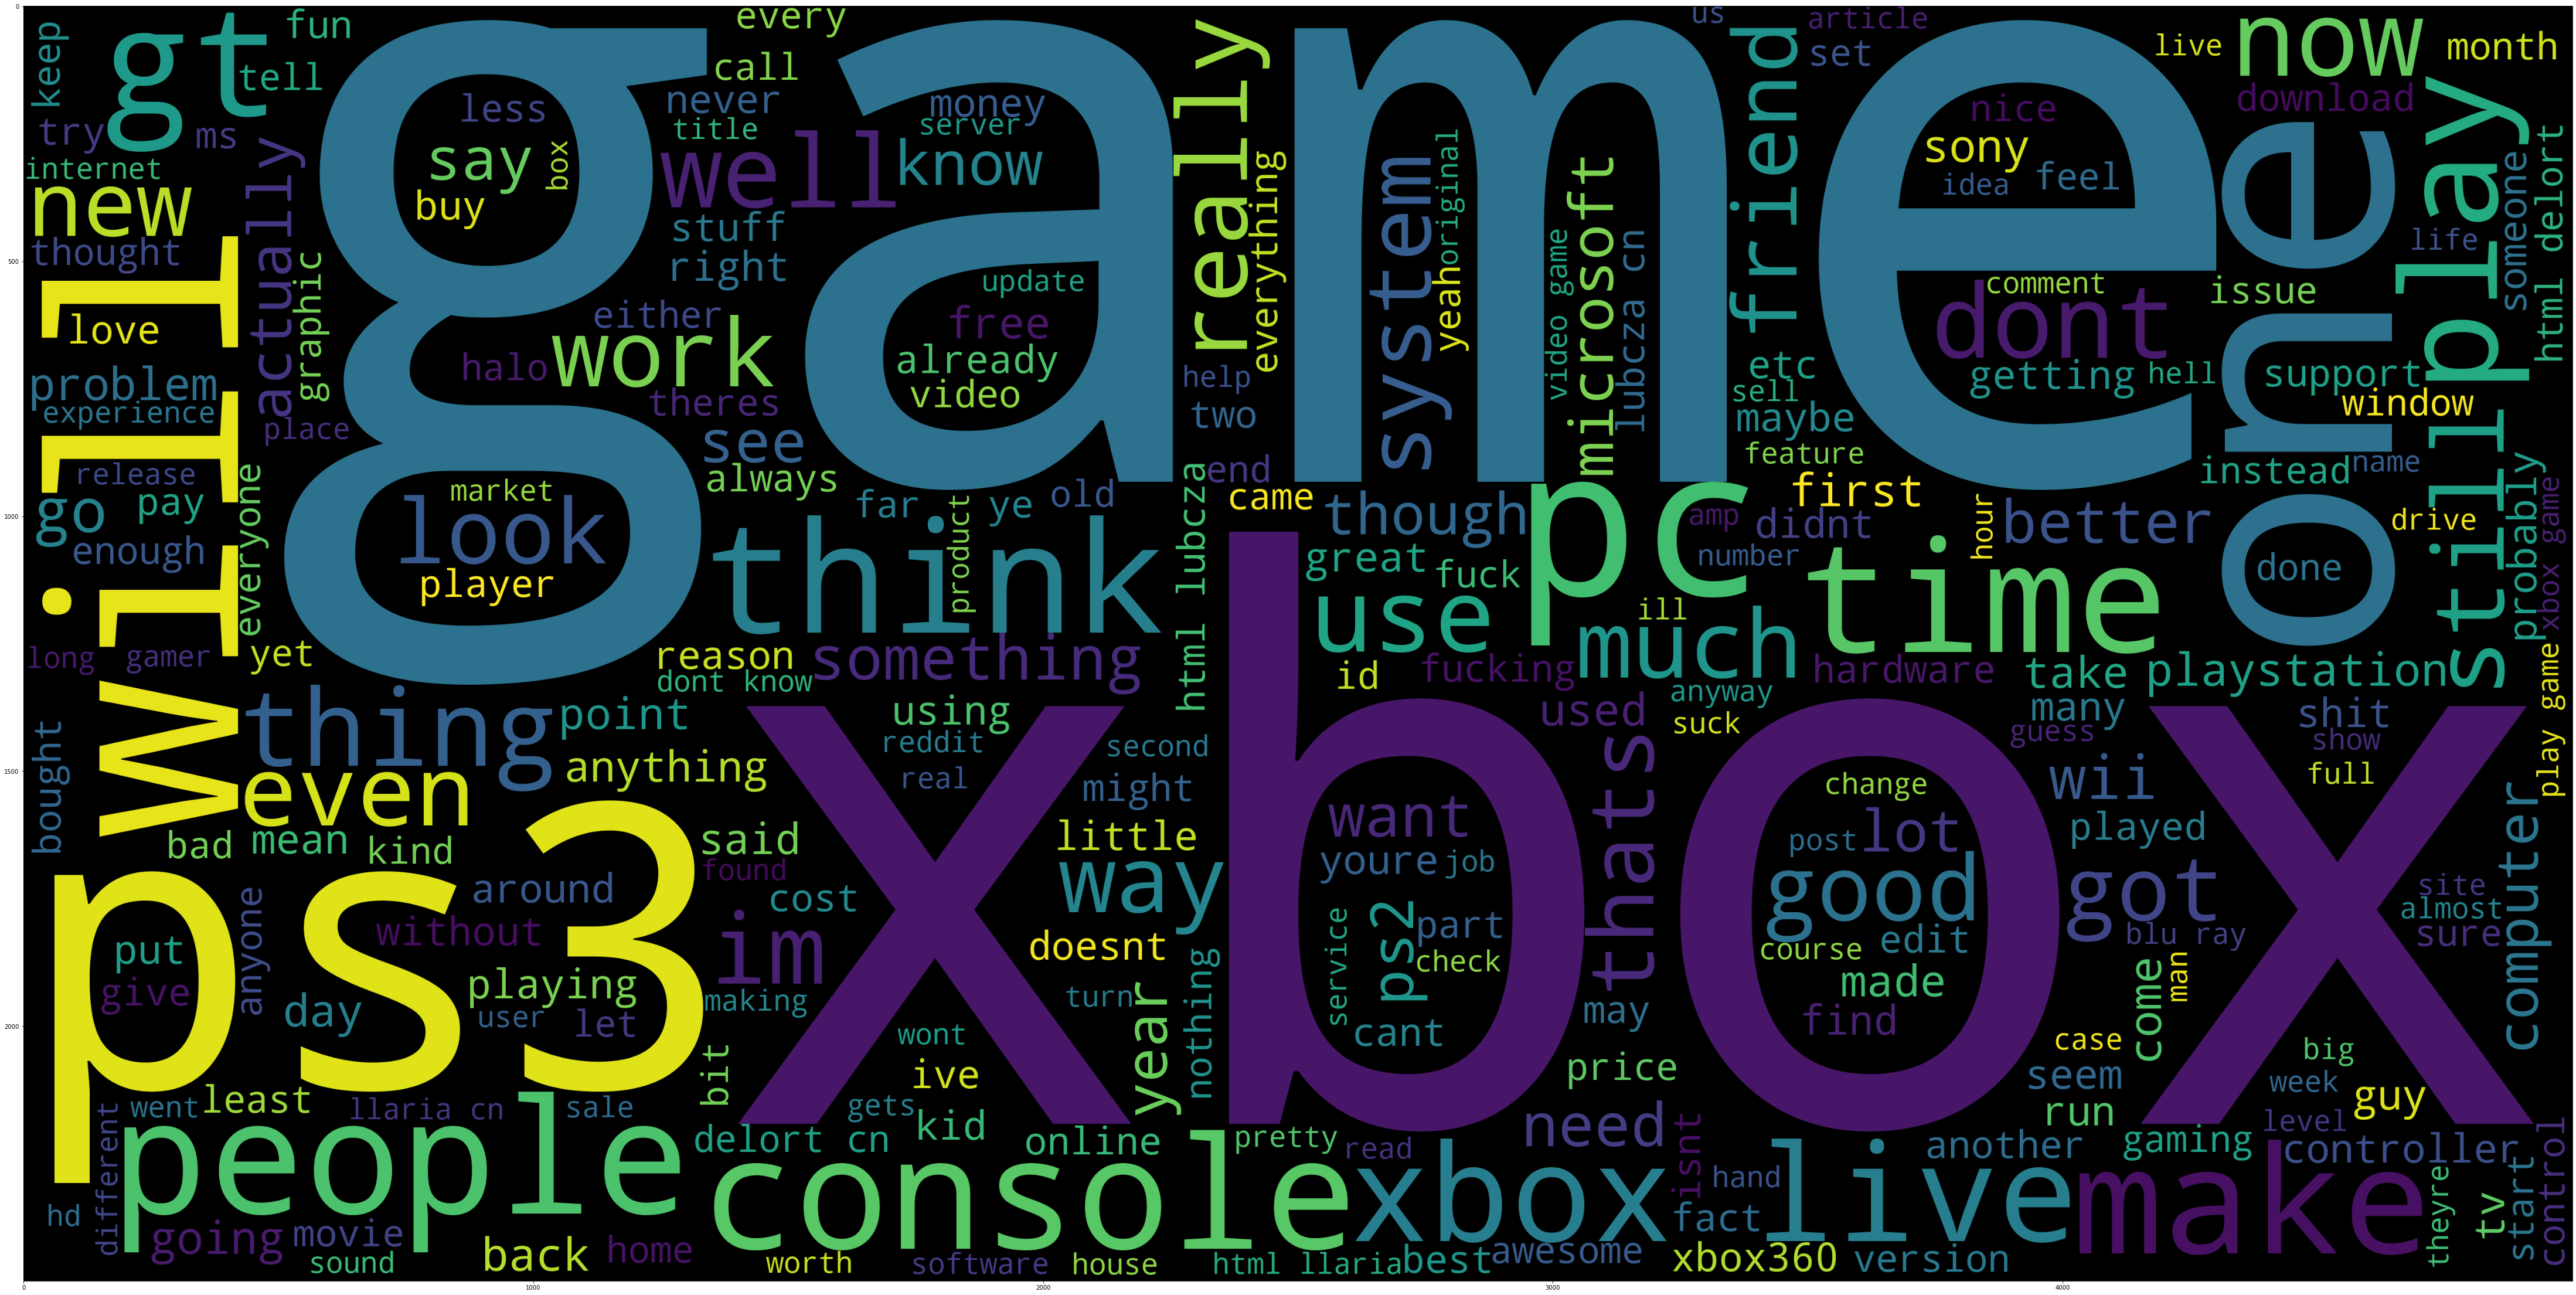

In [69]:
from wordcloud import WordCloud, STOPWORDS

test_range = range(df['body'].count())
stopwords = STOPWORDS
superstring = ""

for i in test_range:
    test_string = df['body'].iloc[i]
    superstring += test_string
    
wc = WordCloud(width=5000, height=2500, max_words=250, stopwords=stopwords).generate(superstring)
plt.figure(figsize=(80, 40))
plt.imshow(wc)
plt.show()

Looking at the top 250 words across all of the posts, there are plenty of phrases you'd expect to see,
such as game, xbox, xbox live, system, ps3, player, download, console, pc, gaming, and play.
Amongst the remaining words, we can see some indications of positive sentiment, such as awesome, love, new, great,
original, need, good, and pretty, although there is a fair amount of negative sentiment found in words like
never, dont, old, problem, doesnt, suck, issue, wont, and a few swear words that I won't bother listing.
These are the types of phrases my machine learning will have to sift through in order to properly score
each post.

In [13]:
df.to_json('dataframes/reddit_data.json')